In [19]:
#Install ipython-sql package to run sql in Jupyter
#!pip install ipython-sql
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
#connect with chinook.db 
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [4]:
#SQL query to view all the tables and views available to me
%%sql 
select 
    name,
    type
from
    sqlite_master
    where type IN ("table","view")

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


In [6]:
#List of albums in the DB
%%sql
SELECT *
FROM
album
Limit 5


 * sqlite:///chinook.db
Done.


album_id,title,artist_id
1,For Those About To Rock We Salute You,1
2,Balls to the Wall,2
3,Restless and Wild,2
4,Let There Be Rock,1
5,Big Ones,3


In [8]:
#How to get the table sql in SQLlite
%%sql
select sql 
from sqlite_master
where 
type = 'table'
and
name = 'album'

Done.


sql
"CREATE TABLE [album]( [album_id] INTEGER PRIMARY KEY NOT NULL, [title] NVARCHAR(160) NOT NULL, [artist_id] INTEGER NOT NULL, FOREIGN KEY ([artist_id]) REFERENCES [artist] ([artist_id]) ON DELETE NO ACTION ON UPDATE NO ACTION)"


# Analyzing USA Track Sales data by Genre

Scenario: Our Agents have given us 4 new artists to buy music as mentioned below, which 3 should we go with? :
1. Red Tone(Punk)
2. Slim Jim Bites(Blues)
3. Meteor and the Girls(Pop)
4. Regal(Hip-Hop)

Criteria: What are the current grenres users are listening to, Use the most liked genres and choose the band.

Caveat: You could ignore the band which is up and coming and is introducing a new sound. Need their concert data, ticket sales data,radio request data to verify.

Result:
Over 50% of the Sales in USA are from the Rock Genre.
Alternative & Punk and Metal are Distant 2nd and 3rd with 12.4  and 11.8% of Total Sales respectively.

Genres like: Blues, Pop and Hip-Hop/Rap have have lesser sales overall of 3.42%, 2.09% and 1.90%

The recommendation based on the data is that:
Given the current mood ideally we should keep a search for good Rock bands.
but given the current options we should choose, 
1. Red Tone(Punk)
2. Slim Jim Bites(Blues)
3. Meteor and the Girls(Pop) 

In [38]:

%%sql

WITH 
    customer_invoice AS
    (
        SELECT 
            customer_id cust_id,
            invoice_id invoice,
            invoice_date idate,
            total billing_total
            
        FROM
            invoice i
            LEFT JOIN
            customer c
            ON ( i.customer_id = i.customer_id)
    ),
    invoice_invoice_line AS
    (
        SELECT 
            customer_id custid,
            invoice_line_id invoice_line,
            track_id track_id,
            unit_price unit,
            quantity qu
        FROM
            invoice i
            INNER JOIN
            invoice_line il
            ON (i.invoice_id = il.invoice_id)
            
            
    ),
    track_genre AS
    (
        SELECT 
            t.name track_name,
            track_id track_id,
            album_id album_id,
            g.name genre
        FROM
        TRACK t
        LEFT JOIN
        GENRE g
        ON (t.genre_id = g.genre_id)
        
    ),
    USA_genre_sales AS
    (
        SELECT  
        tg.genre genre,
        sum(iil.qu) Total
        FROM
        track_genre tg
        INNER JOIN
        invoice_invoice_line iil
        ON 
        tg.track_id = iil.track_id
        LEFT JOIN
        customer c
        ON
        c.customer_id = iil.custid
        WHERE
        c.country = 'USA'
        group by 1
    )
     
    
    
SELECT  
    g.genre,
    g.Total Sales,
    CAST(g.Total AS FLOAT)/(select SUM(Total) FROM USA_genre_sales)*100 AS percent_Sales
FROM
USA_genre_sales g
group by 1
Order by 2 desc

Done.


genre,Sales,percent_Sales
Rock,561,53.37773549000951
Alternative & Punk,130,12.369172216936251
Metal,124,11.798287345385347
R&B/Soul,53,5.042816365366318
Blues,36,3.425309229305423
Alternative,35,3.3301617507136063
Latin,22,2.093244529019981
Pop,22,2.093244529019981
Hip Hop/Rap,20,1.9029495718363463
Jazz,14,1.3320647002854424


# Analyzing Sales by each Sales Agent 

Jane Peacock has the most sales made out of the 3 sales agent.
She is ahead of the other 2 by 20%.
Having said that Jane has stayed in the company more than the other 2 employees.
So all the employees are doing well.


In [75]:
%%sql
WITH 
    customer_invoice AS
    (
        SELECT 
            i.customer_id cust_id,
            invoice_id invoice,
            invoice_date idate,
            total billing_total,
            c.support_rep_id employee_id
            
        FROM
            invoice i
            LEFT JOIN
            customer c
            ON ( i.customer_id = c.customer_id)
    )

SELECT 
e.first_name||' '||e.last_name 'Sales Agent Name',
hire_date 'Hire Date',
strftime('%m', ci.idate) Month,
strftime('%Y', ci.idate) Year,

Round(SUM(billing_total),3) 'Total Sales'
FROM
employee e
INNER JOIN
customer_invoice ci


on (e.employee_id = ci.employee_id)
group by 1,2,3,4
order by 4,3


Done.


Sales Agent Name,Hire Date,Month,Year,Total Sales
Jane Peacock,2017-04-01 00:00:00,01,2017,80.19
Margaret Park,2017-05-03 00:00:00,01,2017,41.58
Steve Johnson,2017-10-17 00:00:00,01,2017,4.95
Jane Peacock,2017-04-01 00:00:00,02,2017,82.17
Margaret Park,2017-05-03 00:00:00,02,2017,52.47
Steve Johnson,2017-10-17 00:00:00,02,2017,6.93
Jane Peacock,2017-04-01 00:00:00,03,2017,32.67
Margaret Park,2017-05-03 00:00:00,03,2017,37.62
Steve Johnson,2017-10-17 00:00:00,03,2017,33.66
Jane Peacock,2017-04-01 00:00:00,04,2017,84.15


In [23]:

sq = '''WITH 
    customer_invoice AS
    (
        SELECT 
            i.customer_id cust_id,
            invoice_id invoice,
            invoice_date idate,
            total billing_total,
            c.support_rep_id employee_id
            
        FROM
            invoice i
            LEFT JOIN
            customer c
            ON ( i.customer_id = c.customer_id)
    )

SELECT 
e.first_name||' '||e.last_name 'Sales Agent Name',
hire_date 'Hire Date',
strftime('%m', ci.idate) Month,
strftime('%Y', ci.idate) Year,

Round(SUM(billing_total),3) 'Total Sales'
FROM
employee e
INNER JOIN
customer_invoice ci


on (e.employee_id = ci.employee_id)
group by 1,2,3,4
order by 4,3
'''

Next we should check which countries have a greater chance of growth. although the data we are operating on is less, we can still take small risks and see the results

Criteria: We can look at the data and understand that few regions have higher customer spending that others, we can utilize marketing bugdet to see that the pattern extends to other users in the region as well.

In [21]:

data = %sql  select c.country country,CAST(SUM(Total) as FLOAT)/ COUNT(DISTINCT c.Customer_id) Total FROM CUSTOMER c INNER JOIN  invoice i  on c.customer_id = i.customer_id  GROUP BY   1 ORDER BY 2
df = pd.DataFrame(data,columns = ('country','Averge customer sales'))

 * sqlite:///chinook.db
Done.


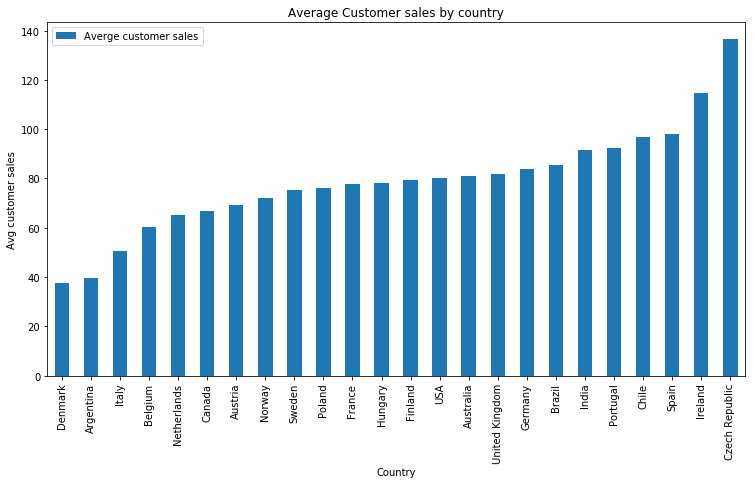

In [22]:
# Plot of App counts by Categories. 
ax = df.plot.bar(x='country', y='Averge customer sales', rot=90)
plt.rcParams["figure.figsize"] = [12.5, 6.5]
plt.title('Average Customer sales by country')
plt.ylabel('Avg customer sales')
plt.xlabel('Country')
plt.show()

#calculating Customer Count, Avg Sales per Order, avg Sales per customer(CLV),Total sales by Each country.

Some of our observations is that:
1. the data is very less to suggest anything
2. We see that countries mentioned below have highest average cost per order.
    i)  Czech Republic 
    ii)  United Kingdom
    iii) India
    iv)  GERMANY
This suggests that people are likely to buy more in these countries. We can market our music product in these markets so that we can see if results follow the same pattern as seen now. 


In [45]:
%%sql
With
    AVG_Sales AS
    (
        select 
        c.country country,
        AVG(Total) Total
        FROM 
        CUSTOMER c
        INNER JOIN
        invoice i
        on c.customer_id = i.customer_id
        GROUP BY
        1
    ),
    sales_by_cust AS
    (       
            select 
            c.country country,
            CAST(SUM(Total) as FLOAT)/ COUNT(DISTINCT c.Customer_id) CLV,
            Sum(Total) total_value_of_Sales,
            COUNT(DISTINCT i.CUSTOMER_id) customer_count
            FROM 
            CUSTOMER c
            INNER JOIN
            invoice i
            on c.customer_id = i.customer_id
            GROUP BY
            1
    ),
    OUTPUT AS
    (
        SELECT 
        CASE
        WHEN cs.customer_count > 1 THEN cs.country
        ELSE 'Other'
        END as country,
        AVG(cs.CLV) AS CLV,
        SUM(cs.total_value_of_Sales) AS sales_total ,
        SUM(cs.customer_count) as customer_count,
        AVG(asc.Total) as avg_amount_per_Order
        FROM
        sales_by_cust cs
        LEFT JOIN
        AVG_Sales asc
        ON 
        (asc.country = cs.country)
        group by 1
        order by 4 desc
    
    ),
    OUTPUT_MOD AS
    (
        SELECT
        CASE
        WHEN country = 'Other'
        THEN 1
        ELSE 0
        END AS Flag,
        O.*
        FROM
        OUTPUT O
    )

    
SELECT Country,CLV,sales_total,customer_count,avg_amount_per_order FROM OUTPUT_MOD mod
ORDER BY FLAG,5 desc

Done.


country,CLV,sales_total,customer_count,avg_amount_per_Order
Czech Republic,136.62000000000003,273.24000000000007,2,9.108000000000002
United Kingdom,81.84,245.52,3,8.768571428571429
India,91.57499999999999,183.14999999999998,2,8.72142857142857
Germany,83.655,334.62,4,8.161463414634147
USA,80.0376923076923,1040.4899999999998,13,7.942671755725189
France,77.81399999999998,389.0699999999999,5,7.781399999999998
Canada,66.94875000000002,535.5900000000001,8,7.047236842105265
Brazil,85.53600000000002,427.68000000000006,5,7.0111475409836075
Portugal,92.56500000000001,185.13000000000002,2,6.383793103448276
Other,72.996,1094.9399999999998,15,7.445071062271063


# Monetization strategy: Check weather making album purchases makes sense

In [50]:
%%sql
SELECT
i.invoice_id,
il.track_id,
t.album_id
FROM
INVOICE i
LEFT JOIN
INVOICE_LINE il
ON (i.invoice_id = il.invoice_id)
LEFT JOIN
track t
ON
(t.track_id = il.track_id)
ORDER BY 1


Done.


invoice_id,track_id,album_id
1,1158,91
1,1159,91
1,1160,91
1,1161,91
1,1162,91
1,1163,91
1,1164,91
1,1165,91
1,1166,91
1,1167,91


18% of the sales contribute to people only buying albums .Changing strtergy to Not buying albums is not recommended as we would effectively distrupt 1/5 of our sales.

so the recommendation be to keep buying albums

In [16]:
%%sql
WITH
    out AS
    (
        SELECT
        i.invoice_id,
        MIN(il.track_id),
        (
                (
                        SELECT
                        il.track_id
                        FROM
                        INVOICE i1
                        LEFT JOIN
                        INVOICE_LINE il
                        ON (i1.invoice_id = il.invoice_id)
						WHERE
                        i1.invoice_id = i.invoice_id


                    EXCEPT

                        SELECT 
                        track_id
                        FROM
                        track t2

                        WHERE  t2.album_id = t.album_id


                ) IS NULL

                AND


                (

                        SELECT 
                        track_id
                        FROM
                        track t2

                        WHERE  t2.album_id = t.album_id


                        EXCEPT

                        SELECT
                        il.track_id
                        FROM
                        INVOICE i1
                        LEFT JOIN
                        INVOICE_LINE il
                        ON (i1.invoice_id = il.invoice_id)
						WHERE
                        i1.invoice_id = i.invoice_id


                ) IS NULL

        ) as Flag
        FROM
        INVOICE i
        LEFT JOIN
        INVOICE_LINE il
        ON (i.invoice_id = il.invoice_id)
        LEFT JOIN
        track t
        ON
        (t.track_id = il.track_id)
        group by 1
    ),
    album_not_album AS
    (
        SELECT invoice_id, 
        CASE 
        WHEN sum(Flag) >0 THEN 'album'
        WHEN SUM(Flag) = 0 THEN 'not album'
        END AS album_not_album
        FROM OUT O
        Group by 1
    )

select 
album_not_album,
count(album_not_album) as count,
CAST(count(album_not_album) AS FLOAT)/(SELECT count(album_not_album) FROM album_not_album)*100 as count

FROM album_not_album a
group by 1

Done.


album_not_album,count,count_1
album,114,18.566775244299674
not album,500,81.43322475570032


total customers on the App.We need to check how many of them have bought albums and how many have not(inturn buying single records) in each order.

This would help us further solidify our belief that customers are inclined to buy albums as well as single songs and discontinuing albums is not a great idea

Results:
We have total of 59 customers.
Out of which 54 bought albums in their purchase. 
Sales made with albums in the order is 30% of the total sales.(Assumption is that albums make major portion of the sales)

In [26]:
%%sql
select count(Distinct customer_id) 'Total Customer'  from customer c

 * sqlite:///chinook.db
Done.


Total Customer
59


In [32]:
%%sql
WITH
    out AS
    (
        SELECT
        i.invoice_id,
        i.customer_id,
        i.total total,
        MIN(il.track_id),
        (
                (
                        SELECT
                        il.track_id
                        FROM
                        INVOICE i1
                        LEFT JOIN
                        INVOICE_LINE il
                        ON (i1.invoice_id = il.invoice_id)
						WHERE
                        i1.invoice_id = i.invoice_id


                    EXCEPT

                        SELECT 
                        track_id
                        FROM
                        track t2

                        WHERE  t2.album_id = t.album_id


                ) IS NULL

                AND


                (

                        SELECT 
                        track_id
                        FROM
                        track t2

                        WHERE  t2.album_id = t.album_id


                        EXCEPT

                        SELECT
                        il.track_id
                        FROM
                        INVOICE i1
                        LEFT JOIN
                        INVOICE_LINE il
                        ON (i1.invoice_id = il.invoice_id)
						WHERE
                        i1.invoice_id = i.invoice_id


                ) IS NULL

        ) as Flag
        FROM
        INVOICE i
        LEFT JOIN
        INVOICE_LINE il
        ON (i.invoice_id = il.invoice_id)
        LEFT JOIN
        track t
        ON
        (t.track_id = il.track_id)
        group by 1,2
    ),
    album_not_album AS
    (
        SELECT invoice_id, 
        CASE 
        WHEN sum(Flag) >0 THEN 'album'
        WHEN SUM(Flag) = 0 THEN 'not album'
        END AS album_not_album
        FROM OUT O
        Group by 1
    )
    
SELECT CASE 
WHEN FLAG = 1 THEN 'Yes'
WHEN FLAG = 0 THEN 'No'
END AS Album,
count(distinct Customer_id) 'Number of Customers',
Round(SUM(Total),1) AS 'Album Sales' FROM OUT group by 1

 * sqlite:///chinook.db
Done.


Album,Number of Customers,Album Sales
No,59,3248.2
Yes,54,1461.2


In [34]:
#verifing if total is correct 
%sql select SUM(total) from invoice i

 * sqlite:///chinook.db
Done.


SUM(total)
4709.429999999994
